In [1]:
import numpy as np
import gym
import torch
import random
from torch import nn
from torch import optim
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set('notebook')
%config InlineBackend.figure_format = 'retina'

# Parameters

In [2]:
REPLAY_BUFFER_SIZE  = 2000
BATCH_SIZE          = 128
EPS_MAX             = 1.0
EPS_MIN             = 0.1
EPS_DECAY_RATE      = 0.99
GAMMA               = 0.9
LR                  = 0.0001
HIDDEN_SIZE         = 32

# Prioritized experience replay
ALPHA               = 0.7
BETA                = 1.0

SEED                = 4

In [3]:
class SumTree:

    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1 )
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2
        self.tree[parent] += change
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1
        if left >= len(self.tree):
            return idx
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(idx, p)
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]
        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1
        return (idx, self.tree[idx], self.data[dataIdx])



class ReplayBuffer(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = SumTree(capacity)
        self._size = 0
        
    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        if max_priority == 0:
            max_priority = 1

        self.tree.add(max_priority, experience)
        self._size = min(self._size + 1, self.capacity)
        
    def sample(self, n):
        indices = []
        priorities = []
        data_arr = []

        priority_segment = self.tree.tree[0] / n
        for i in range(n):
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            index, priority, data = self.tree.get(value)

            indices += [index]
            priorities += [priority]
            data_arr += [data]

        return indices, priorities, data_arr
    
    def update(self, tree_idx, new_priority):
        self.tree.update(tree_idx, new_priority)

    def size(self):
        return self._size

In [4]:
class ActionValueFunction(nn.Module):
    """
    Represents the action-value q(s,a) using a neural network (Deep RL)

    Returns an array containing the value for every action, i.e. q(s,a) = q(s)[a]
    """
    
    def __init__(self):
        super().__init__()
        self.n_inputs = n_features
        self.n_outputs = n_actions
        self.hidden_size = HIDDEN_SIZE
        
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, self.hidden_size), 
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.n_outputs))
    
    def forward(self, state):
        action_probs = self.network(state)
        return action_probs


def run_episode(replay_buffer):
    """
    Run one episode until termination and return the total reward.
    
    Add every step to the replay buffer and update the actionValue network after each step.
    """

    s0 = env.reset()
    a0 = np.random.choice(range(n_actions), p=epsilon_greedy(s0))

    total_reward = 0

    while True:

        s1, r, done, _ = env.step(a0)
        a1 = np.random.choice(range(n_actions), p=epsilon_greedy(s1))
        replay_buffer.store((s0, a0, r, s1, a1, done))
        s0, a0 = s1, a1

        update()

        total_reward += r
        if done:
            return total_reward


def update():
    """
    Update the actionValue network by sampling experience from the replay buffer
    """

    if replay_buffer.size() < BATCH_SIZE:
        return

    # size of the replay buffer
    N = replay_buffer.size()

    batch_indices, batch_priorities, batch = replay_buffer.sample(BATCH_SIZE)

    # importance sampling weight
    batch_priorities = np.array(batch_priorities)
    w = (N * batch_priorities) ** (-BETA)
    w /= max(w)
    w = torch.tensor(w, dtype=torch.float32).to(device)

    s0 = torch.Tensor([b[0] for b in batch]).to(device)
    a0 = torch.LongTensor([b[1] for b in batch]).to(device)
    r = torch.Tensor([b[2] for b in batch]).to(device)
    s1 = torch.Tensor([b[3] for b in batch]).to(device)
    a1 = torch.LongTensor([b[4] for b in batch]).to(device)
    done = torch.BoolTensor([b[5] for b in batch]).to(device)

    q_target = r + ~done * GAMMA * torch.max(q(s1), dim=1)[0] # Q-Learning
    q_current = torch.gather(q(s0), 1, a0.unsqueeze(1)).squeeze()

    # update priorities
    for i, idx in enumerate(batch_indices):
        new_priority = abs(q_target[i] - q_current[i]).item()
        new_priority += 0.001 # add small epsilon (see paper)
        new_priority = new_priority ** ALPHA
        replay_buffer.update(idx, new_priority)

    loss = torch.nn.functional.mse_loss(q_target, q_current, reduction='none')
    loss = torch.dot(loss, w) # importance sampling
    optim.zero_grad()
    loss.backward()
    optim.step()


def epsilon_greedy(s):
    """
    Epsilon-greedy policy
    """

    if random.random() < eps:
        return np.ones(n_actions) / n_actions

    s = torch.Tensor(s).to(device)
    q_values = q(s).cpu().detach().numpy()
    return np.identity(n_actions)[np.argmax(q_values)]


def set_seed(seed):
    """ Sets the seeds """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    env.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
env             = gym.make('CartPole-v0')
reward_hist     = []
n_actions       = env.action_space.n
n_features      = env.observation_space.shape[0]

q               = ActionValueFunction().to(device)
optim           = torch.optim.Adam(q.parameters(), lr=LR)
replay_buffer   = ReplayBuffer(REPLAY_BUFFER_SIZE)
eps             = EPS_MAX

set_seed(SEED)

for i in range(5000):

    # update epsilon
    eps = max(EPS_MIN, eps * EPS_DECAY_RATE)

    total_reward = run_episode(replay_buffer)
    reward_hist += [total_reward]

    print('\repisode: {} \t average reward (last 100): {:.2f} \t current reward: {:.0f} \t eps: {:.2f}'.format(i, np.mean(reward_hist[-100:]), total_reward, eps), end="")
    
    if np.mean(reward_hist[-100:]) >= 195: break


episode: 2504 	 average reward (last 100): 195.59 	 current reward: 200 	 eps: 0.10

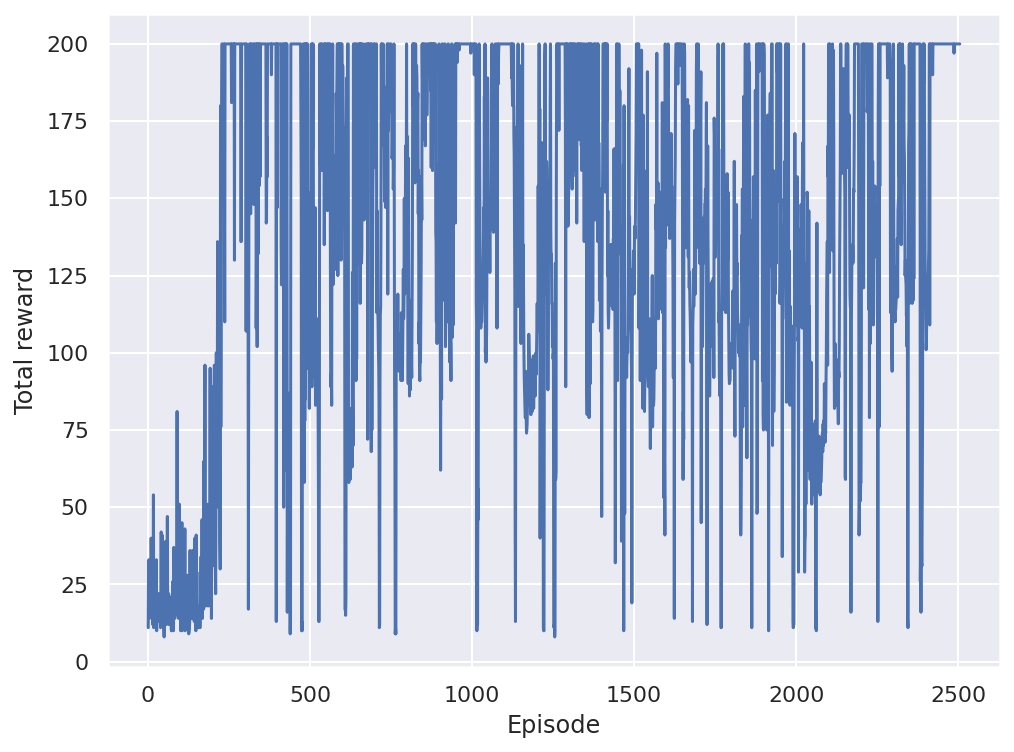

In [6]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1,len(reward_hist)+1), y=reward_hist)
plt.xlabel("Episode")
plt.ylabel("Total reward");

# Observations

Works with
- gamma = 0.9, 0.95 (high sensitivity)
- lr = 0.0001 (high sensitivity)
- hidden size = 32, 64
- larger replay buffer
- if terminal states are penalized
- batch norm does not work (neither before or after the ReLU)